In [31]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter

import os
import glob
import random
import cv2
from pathlib import Path

In [32]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# Load the image dataset
image_directory = "/kaggle/input/ham10000/Data/Data/train"

# Dictionary to map label indices to class names
class_names = {0: 'KERT', 1: 'MELANOMA', 2: 'NEVI'}

Found 5906 files belonging to 3 classes.
Loading sample images for visualization...
Loading images for visualization...

Dataset Overview Visualization


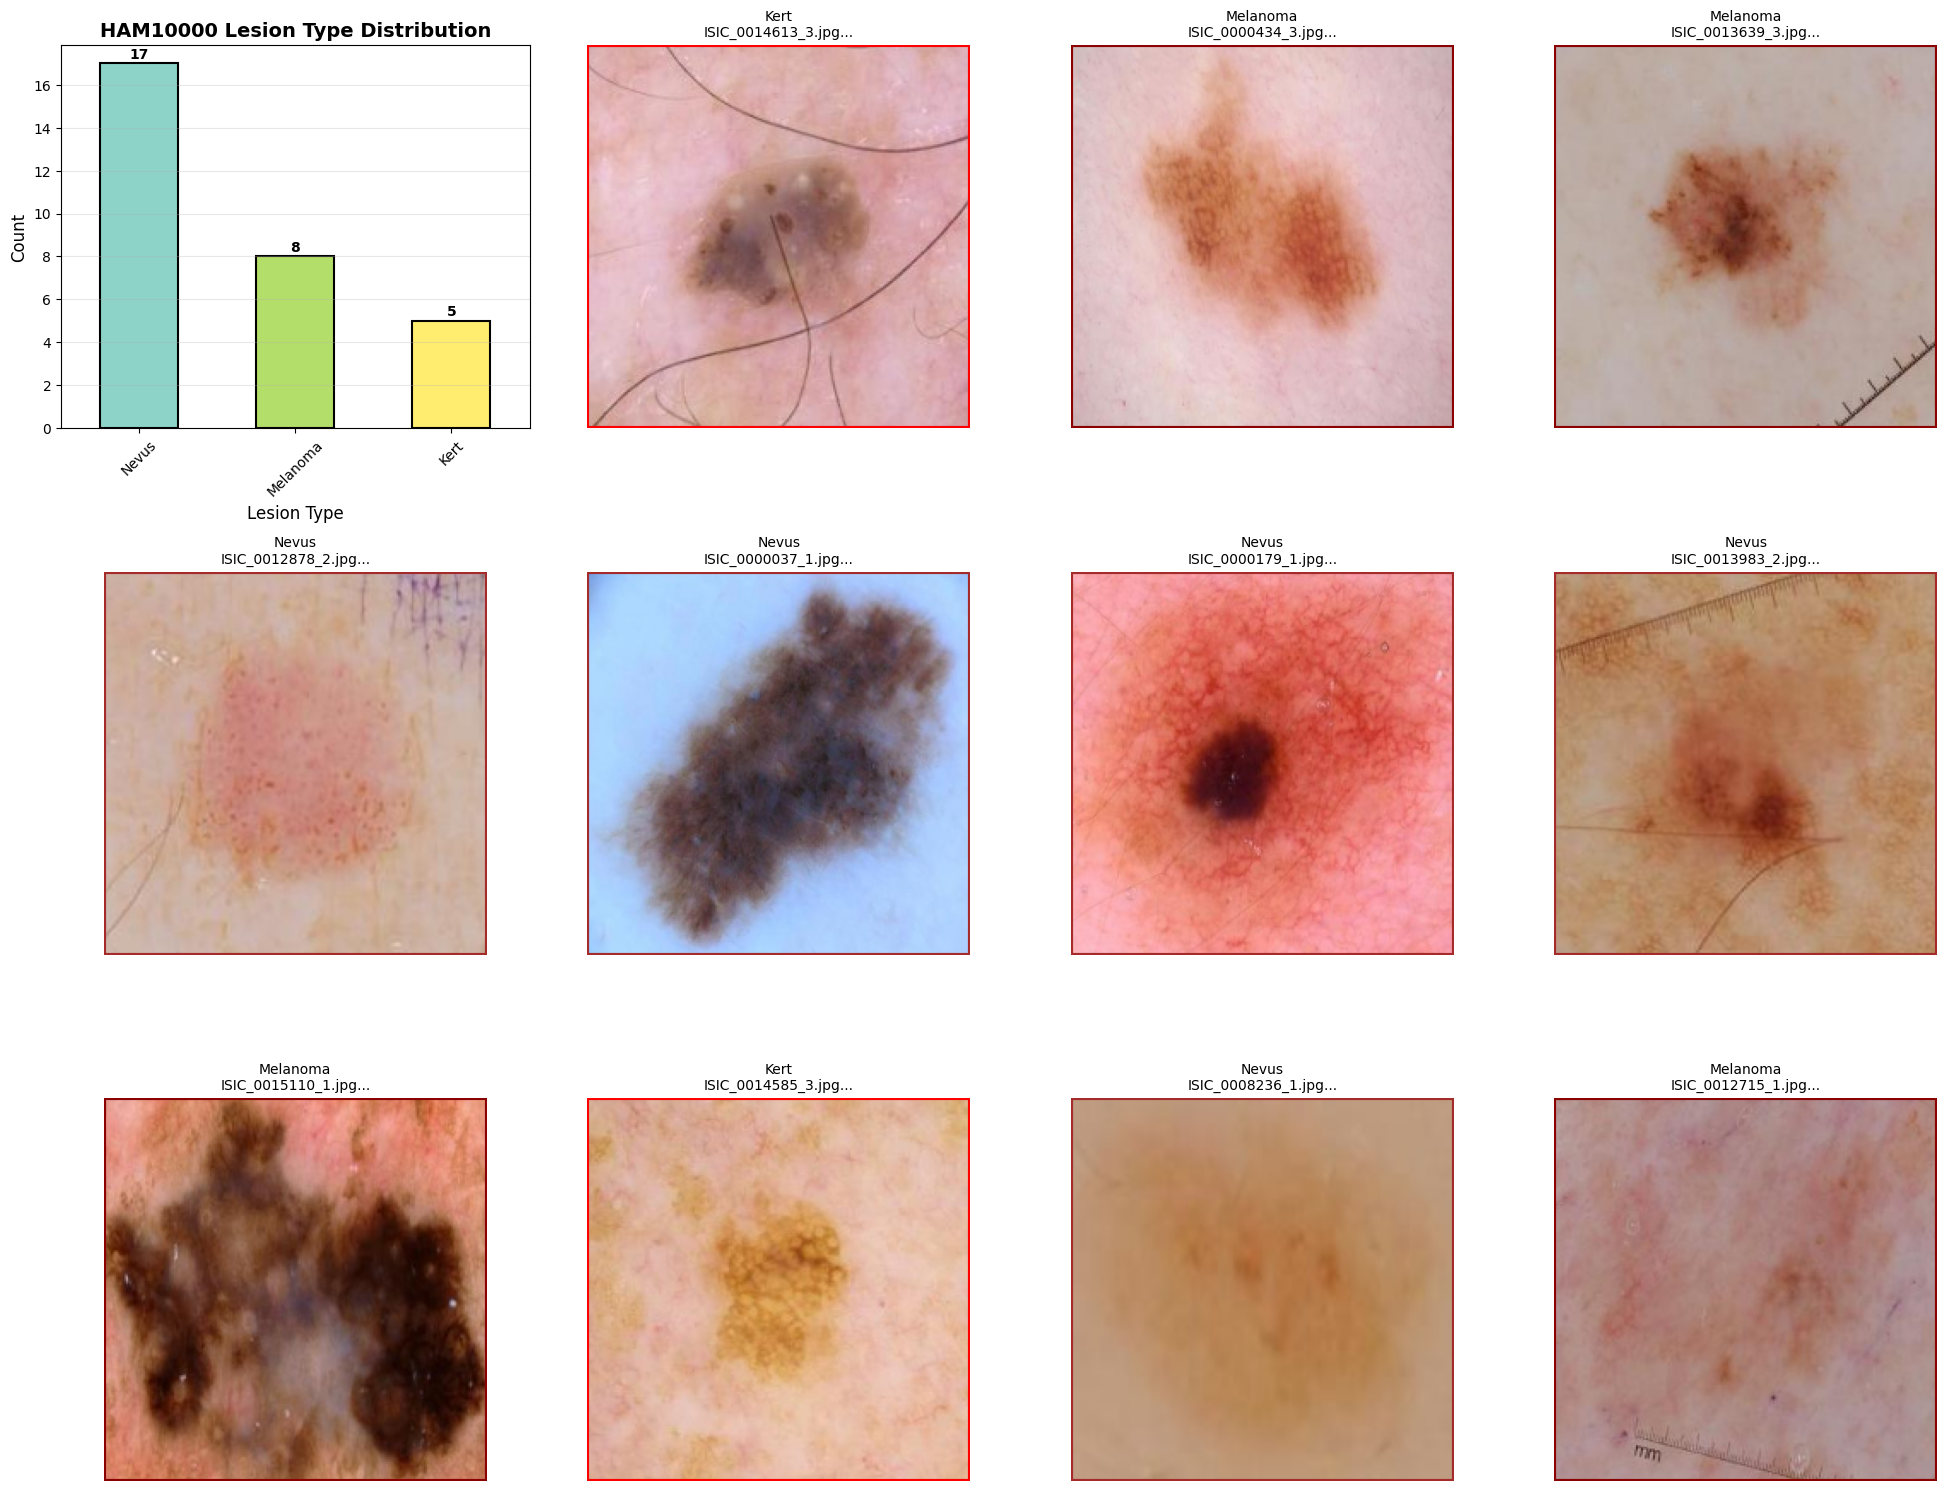


Dataset Statistics:
Total images: 30
Image dimensions: (224, 224, 3)
Unique lesion types: 3
Data type: uint8
Value range: [50.000, 248.000]

Comparing Mask Generation Methods


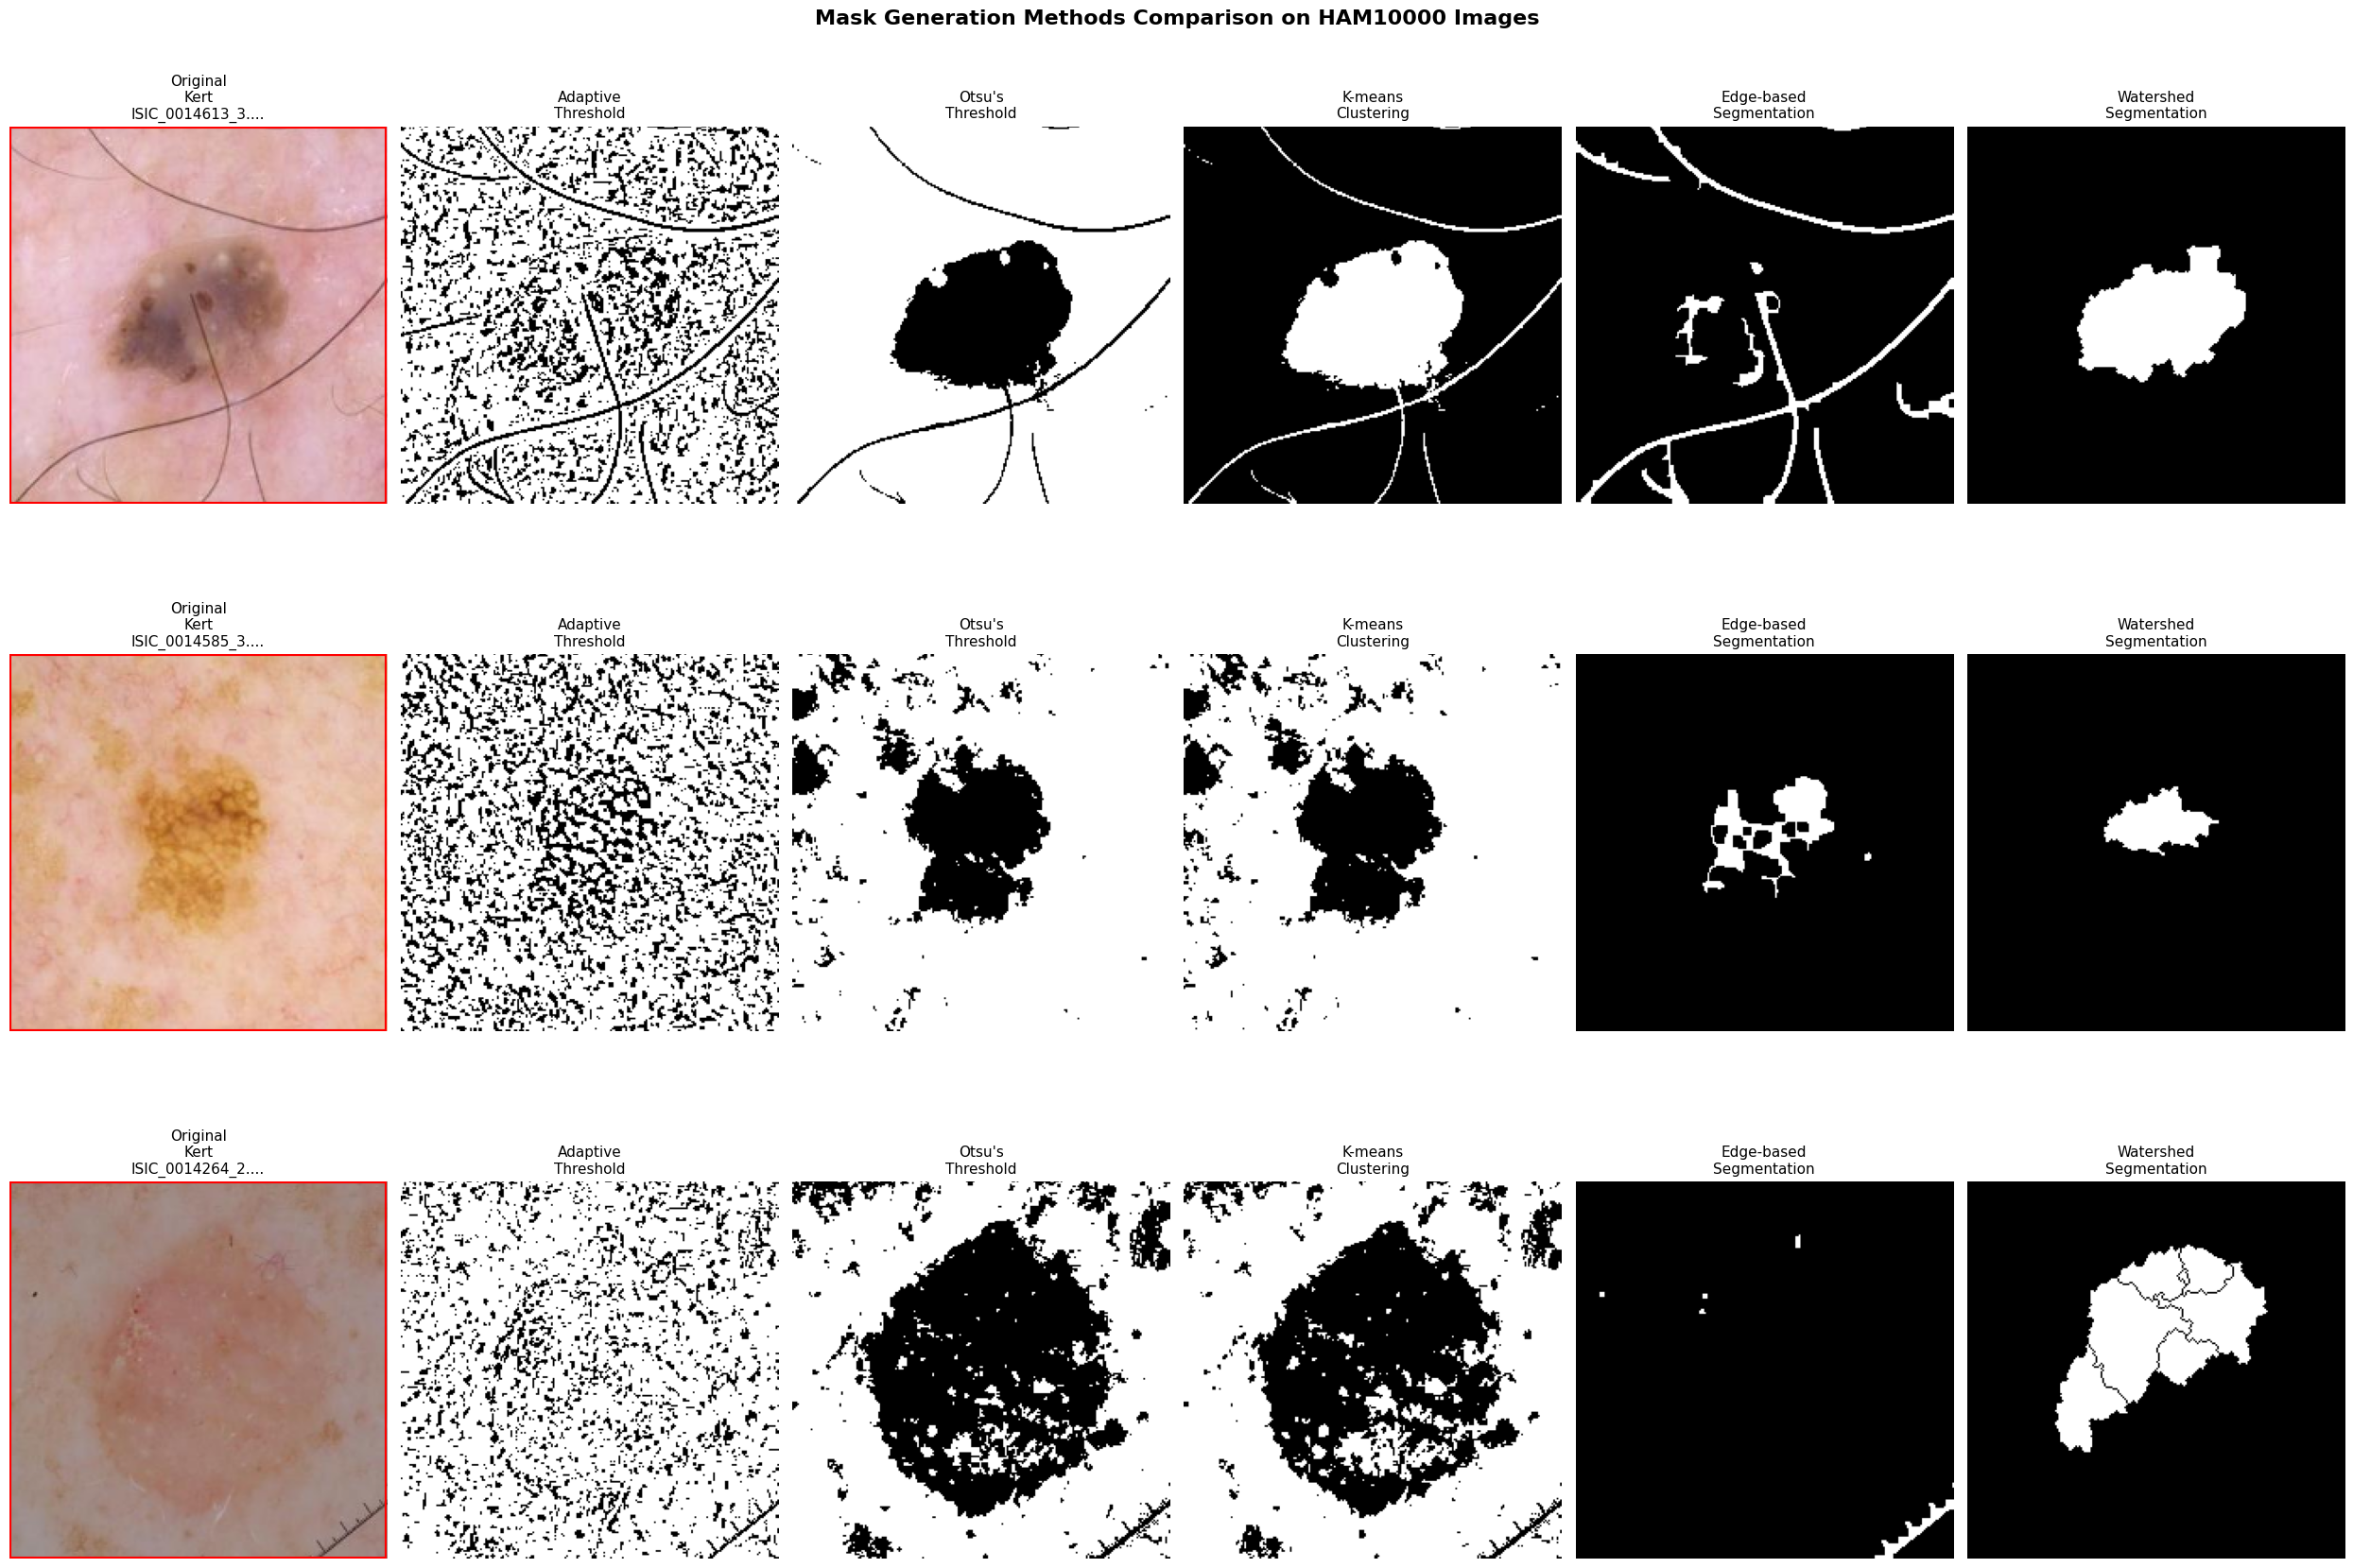

In [33]:
def visualize_dataset_overview(images, labels, file_paths, n_samples=12):

    print("\nDataset Overview Visualization")
    
    # Count lesion types
    lesion_counts = pd.Series(labels).value_counts()
    
    fig = plt.figure(figsize=(20, 15))
    
    # Plot lesion type distribution
    plt.subplot(3, 4, 1)
    colors = plt.cm.Set3(np.linspace(0, 1, len(lesion_counts)))
    bars = lesion_counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=1.5)
    plt.title('HAM10000 Lesion Type Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Lesion Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(lesion_counts.values):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    # Display sample images
    for i in range(min(n_samples-1, len(images))):
        plt.subplot(3, 4, i+2)
        plt.imshow(images[i])
        plt.title(f'{labels[i]}\n{os.path.basename(file_paths[i])[:20]}...', fontsize=10)
        plt.axis('off')
        
        # Add border color based on lesion type
        if labels[i] == 'Kert':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Melanoma':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='darkred', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Nevus':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='brown', linewidth=3, transform=plt.gca().transAxes))
        elif labels[i] == 'Basal_Cell':
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='blue', linewidth=3, transform=plt.gca().transAxes))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed dataset statistics
    print("\nDataset Statistics:")
    print(f"Total images: {len(images)}")
    print(f"Image dimensions: {images[0].shape}")
    print(f"Unique lesion types: {len(lesion_counts)}")
    print(f"Data type: {images[0].dtype}")
    print(f"Value range: [{images[0].min():.3f}, {images[0].max():.3f}]")

def generate_synthetic_masks(images, method='adaptive_threshold'):

    masks = []
    
    for img in images:
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
        
        if method == 'adaptive_threshold':
            # Adaptive thresholding
            mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)
        elif method == 'otsu':
            # Otsu's thresholding
            _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif method == 'kmeans':
            # K-means clustering
            data = gray.reshape((-1, 1))
            data = np.float32(data)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            _, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            labels = labels.reshape(gray.shape)
            mask = (labels == 0).astype(np.uint8) * 255
        elif method == 'edge_based':
            # Edge-based segmentation
            edges = cv2.Canny(gray, 50, 150)
            mask = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
        elif method == 'watershed':
            # Watershed segmentation
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = np.ones((3,3), np.uint8)
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
            sure_bg = cv2.dilate(opening, kernel, iterations=3)
            dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
            _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg, sure_fg)
            _, markers = cv2.connectedComponents(sure_fg)
            markers = markers + 1
            markers[unknown == 255] = 0
            markers = cv2.watershed(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB), markers)
            mask = (markers > 1).astype(np.uint8) * 255
        
        masks.append(mask)
    
    return masks

def visualize_mask_generation_methods(images, labels, file_paths, n_samples=3):

    print("\nComparing Mask Generation Methods")
    
    methods = ['adaptive_threshold', 'otsu', 'kmeans', 'edge_based', 'watershed']
    method_descriptions = {
        'adaptive_threshold': 'Adaptive\nThreshold',
        'otsu': "Otsu's\nThreshold",
        'kmeans': 'K-means\nClustering',
        'edge_based': 'Edge-based\nSegmentation',
        'watershed': 'Watershed\nSegmentation'
    }
    
    fig, axes = plt.subplots(n_samples, len(methods) + 1, figsize=(25, 6*n_samples))
    fig.suptitle('Mask Generation Methods Comparison on HAM10000 Images', fontsize=16, fontweight='bold')
    
    # Focus on Keratosis images first
    kert_indices = [i for i, label in enumerate(labels) if label == 'Kert']
    other_indices = [i for i, label in enumerate(labels) if label != 'Kert']
    
    # Prioritize Keratosis images
    sample_indices = kert_indices[:n_samples] + other_indices[:max(0, n_samples - len(kert_indices))]
    sample_indices = sample_indices[:n_samples]
    
    for i, idx in enumerate(sample_indices):
        img = images[idx]
        
        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original\n{labels[idx]}\n{os.path.basename(file_paths[idx])[:15]}...', fontsize=11)
        axes[i, 0].axis('off')
        
        # Add special border for Keratosis
        if labels[idx] == 'Kert':
            axes[i, 0].add_patch(plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', linewidth=3, transform=axes[i, 0].transAxes))
        
        # Generate masks with different methods
        for j, method in enumerate(methods):
            try:
                mask = generate_synthetic_masks([img], method=method)[0]
                axes[i, j+1].imshow(mask, cmap='gray')
                axes[i, j+1].set_title(method_descriptions[method], fontsize=11)
                axes[i, j+1].axis('off')
            except Exception as e:
                axes[i, j+1].text(0.5, 0.5, f'Error\n{str(e)[:15]}...', 
                                 ha='center', va='center', transform=axes[i, j+1].transAxes,
                                 fontsize=10, color='red')
                axes[i, j+1].set_title(f'{method_descriptions[method]}\n(Error)', fontsize=11)
                axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def load_and_preprocess_images_for_visualization(image_directory, n_samples=50):
    
    print("Loading images for visualization...")
    
    images = []
    labels = []
    file_paths = []
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    
    for ext in image_extensions:
        image_files.extend(list(Path(image_directory).glob(f'**/*{ext}')))
    
    # Sample random images
    if len(image_files) > n_samples:
        random.seed(42)
        image_files = random.sample(image_files, n_samples)
    
    for img_path in image_files:
        try:
            # Load image
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                
                # Infer label from folder structure or filename
                parent_folder = img_path.parent.name.upper()
                if 'KERT' in parent_folder or 'AK' in parent_folder:
                    label = 'Kert'
                elif 'MEL' in parent_folder or 'MELANOMA' in parent_folder:
                    label = 'Melanoma'
                elif 'NEV' in parent_folder or 'NEVUS' in parent_folder:
                    label = 'Nevus'
                elif 'BCC' in parent_folder or 'BASAL' in parent_folder:
                    label = 'Basal_Cell'
                else:
                    label = 'Unknown'
                
                images.append(img)
                labels.append(label)
                file_paths.append(str(img_path))
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
    
    return images, labels, file_paths

# Create initial dataset to analyze class distribution
initial_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

# Load images for visualization
print("Loading sample images for visualization...")
sample_images, sample_labels, sample_file_paths = load_and_preprocess_images_for_visualization(image_directory, n_samples=30)

# Call the visualization functions
if sample_images:
    visualize_dataset_overview(sample_images, sample_labels, sample_file_paths, n_samples=12)
    visualize_mask_generation_methods(sample_images, sample_labels, sample_file_paths, n_samples=3)
else:
    print("No sample images loaded. Skipping visualizations.")

In [34]:
# Dictionary to map label indices to class names
class_names = {0: 'KERT', 1: 'MELANOMA', 2: 'NEVI'}

# Create initial dataset to analyze class distribution
initial_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 5906 files belonging to 3 classes.


In [35]:
# Calculate class weights for handling imbalance
def calculate_class_weights(class_distribution):
    """Calculate class weights to handle imbalance"""
    classes = list(class_distribution.keys())
    class_indices = [list(class_names.values()).index(cls) for cls in classes]
    class_counts = list(class_distribution.values())
    
    # Calculate weights inversely proportional to class frequencies
    total_samples = sum(class_counts)
    n_classes = len(classes)
    
    class_weights = {}
    for i, class_idx in enumerate(class_indices):
        weight = total_samples / (n_classes * class_counts[i])
        class_weights[class_idx] = weight
    
    print("\nCalculated Class Weights:")
    for class_idx, weight in class_weights.items():
        class_name = class_names[class_idx]
        print(f"{class_name}: {weight:.3f}")
    
    return class_weights

class_weights = calculate_class_weights(class_distribution)


Calculated Class Weights:
KERT: 2.604
MELANOMA: 1.806
NEVI: 0.485


In [36]:
# Enhanced data augmentation for better generalization
def create_augmentation_pipeline():
    """Create comprehensive data augmentation pipeline"""
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
        tf.keras.layers.experimental.preprocessing.RandomBrightness(0.2),
        # Add gaussian noise
        tf.keras.layers.GaussianNoise(0.1),
    ])

In [37]:
# Enhanced data augmentation for better generalization (compatible version)
def create_augmentation_pipeline():
    """Create comprehensive data augmentation pipeline"""
    try:
        # Try modern API first
        return tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.3),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
            tf.keras.layers.GaussianNoise(0.1),
        ])
    except AttributeError:
        # Fall back to experimental API for older versions
        try:
            return tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
                tf.keras.layers.experimental.preprocessing.RandomBrightness(0.2),
                tf.keras.layers.GaussianNoise(0.1),
            ])
        except AttributeError:
            # Minimal augmentation for very old versions
            print("Using minimal augmentation due to TensorFlow version compatibility")
            return tf.keras.Sequential([
                tf.keras.layers.Lambda(lambda x: tf.image.random_flip_left_right(x)),
                tf.keras.layers.Lambda(lambda x: tf.image.random_flip_up_down(x)),
                tf.keras.layers.GaussianNoise(0.1),
            ])

In [38]:
# Create datasets with enhanced augmentation
dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

# Apply enhanced augmentation
print("Creating augmentation pipeline...")
data_augmentation = create_augmentation_pipeline()
augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 5906 files belonging to 3 classes.
Using 4725 files for training.
Found 5906 files belonging to 3 classes.
Using 1181 files for validation.
Creating augmentation pipeline...


In [39]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
augmented_dataset = augmented_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [40]:
# Improved CNN model with regularization
def create_improved_model(input_shape=(224, 224, 3), num_classes=3):
    """Create improved CNN model with better regularization"""
    
    # Clear any previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Fourth convolutional block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # Global average pooling instead of flatten (reduces overfitting)
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense layers with regularization
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the improved model
model = create_improved_model()
model.summary()

# Compile with appropriate optimizer and learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model with class weights
print("Training model with class weights to handle imbalance...")
history = model.fit(
    augmented_dataset,
    validation_data=validation_dataset,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,440,931 (5.50 MB)

 Trainable params: 1,438,435 (5.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

Training model with class weights to handle imbalance...
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3428 - loss: 1.8063 - precision: 0.3437 - recall: 0.2917
Epoch 1: val_loss improved from inf to 1.24535, saving model to best_model.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 540ms/step - accuracy: 0.3429 - loss: 1.8052 - precision: 0.3438 - recall: 0.2917 - val_accuracy: 0.3099 - val_loss: 1.2453 - val_precision: 0.2697 - val_recall: 0.1626 - learning_rate: 0.0010
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3830 - loss: 1.4513 - precision: 0.3890 - recall: 0.2916
Epoch 2: val_loss did not improve from 1.24535
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.3830 - loss: 1.4506 - precision: 0.3890 - recall: 0.2915 - val_accuracy: 0.2862 - val_loss: 1.2805 - val_precision: 0.2606 - val_recall: 0.1668 - learning_rate: 0.0010
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3768 - loss: 1.2240 - precision: 0.3806 - recall: 0

In [41]:
# Comprehensive evaluation functions
def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision', color='blue')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='red')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall', color='blue')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', color='red')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


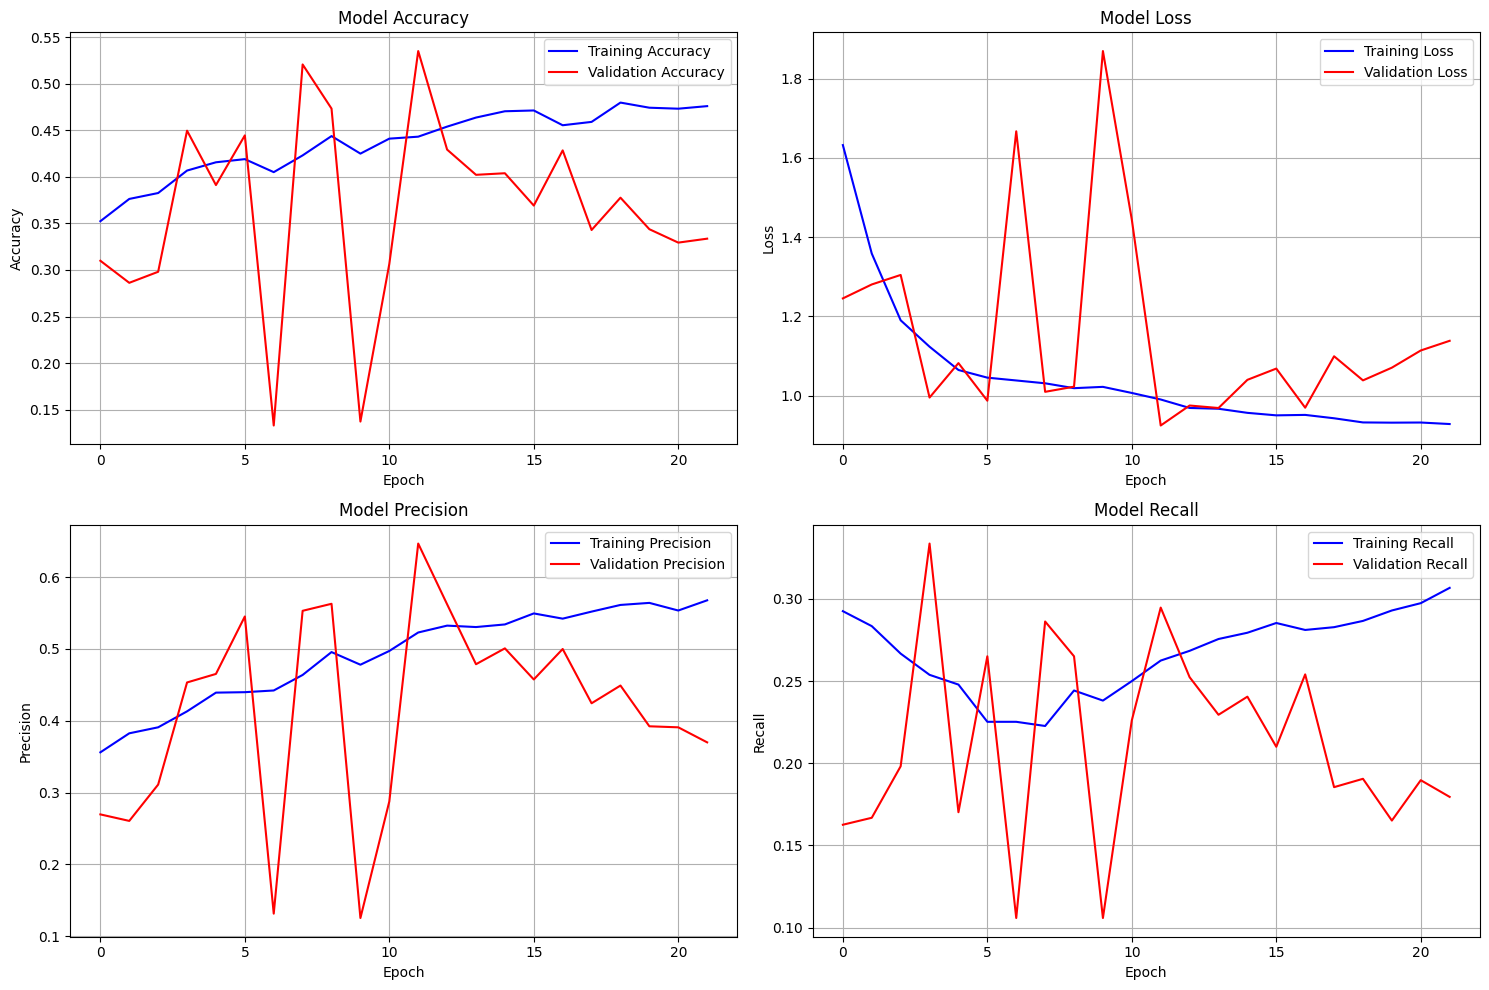

Classification Report:
              precision    recall  f1-score   support

        KERT       0.29      0.68      0.41       129
    MELANOMA       0.22      0.30      0.26       207
        NEVI       0.81      0.57      0.67       845

    accuracy                           0.54      1181
   macro avg       0.44      0.52      0.44      1181
weighted avg       0.65      0.54      0.57      1181



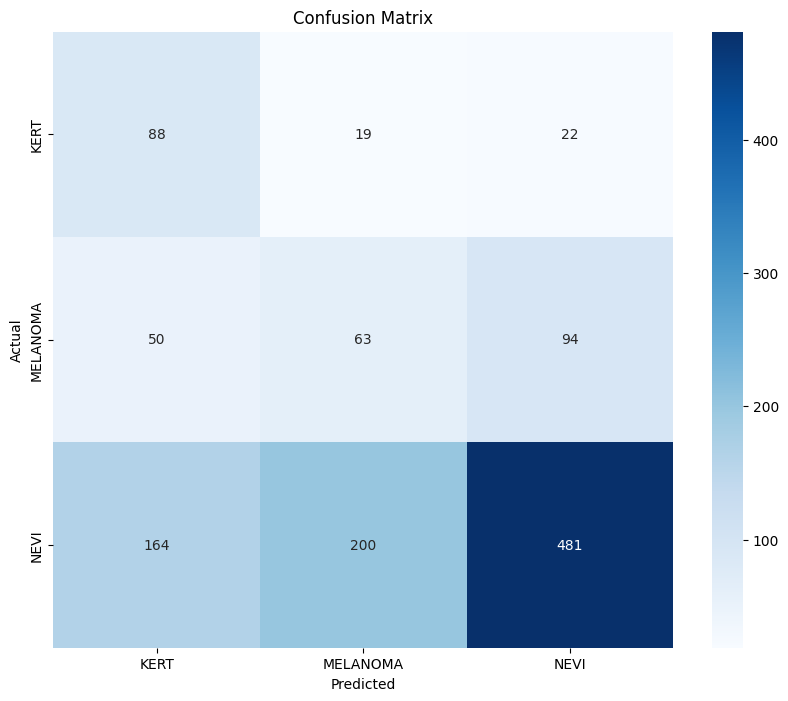


Per-class Accuracy:
KERT: 0.682
MELANOMA: 0.304
NEVI: 0.569


In [42]:
def evaluate_model(model, validation_dataset, class_names):
    """Comprehensive model evaluation"""
    # Get predictions
    y_pred = []
    y_true = []
    
    for images, labels in validation_dataset:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=list(class_names.values())))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(class_names.values()),
                yticklabels=list(class_names.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, acc in enumerate(class_accuracy):
        print(f"{list(class_names.values())[i]}: {acc:.3f}")

# Plot training history
plot_training_history(history)

# Evaluate the model
evaluate_model(model, validation_dataset, class_names)

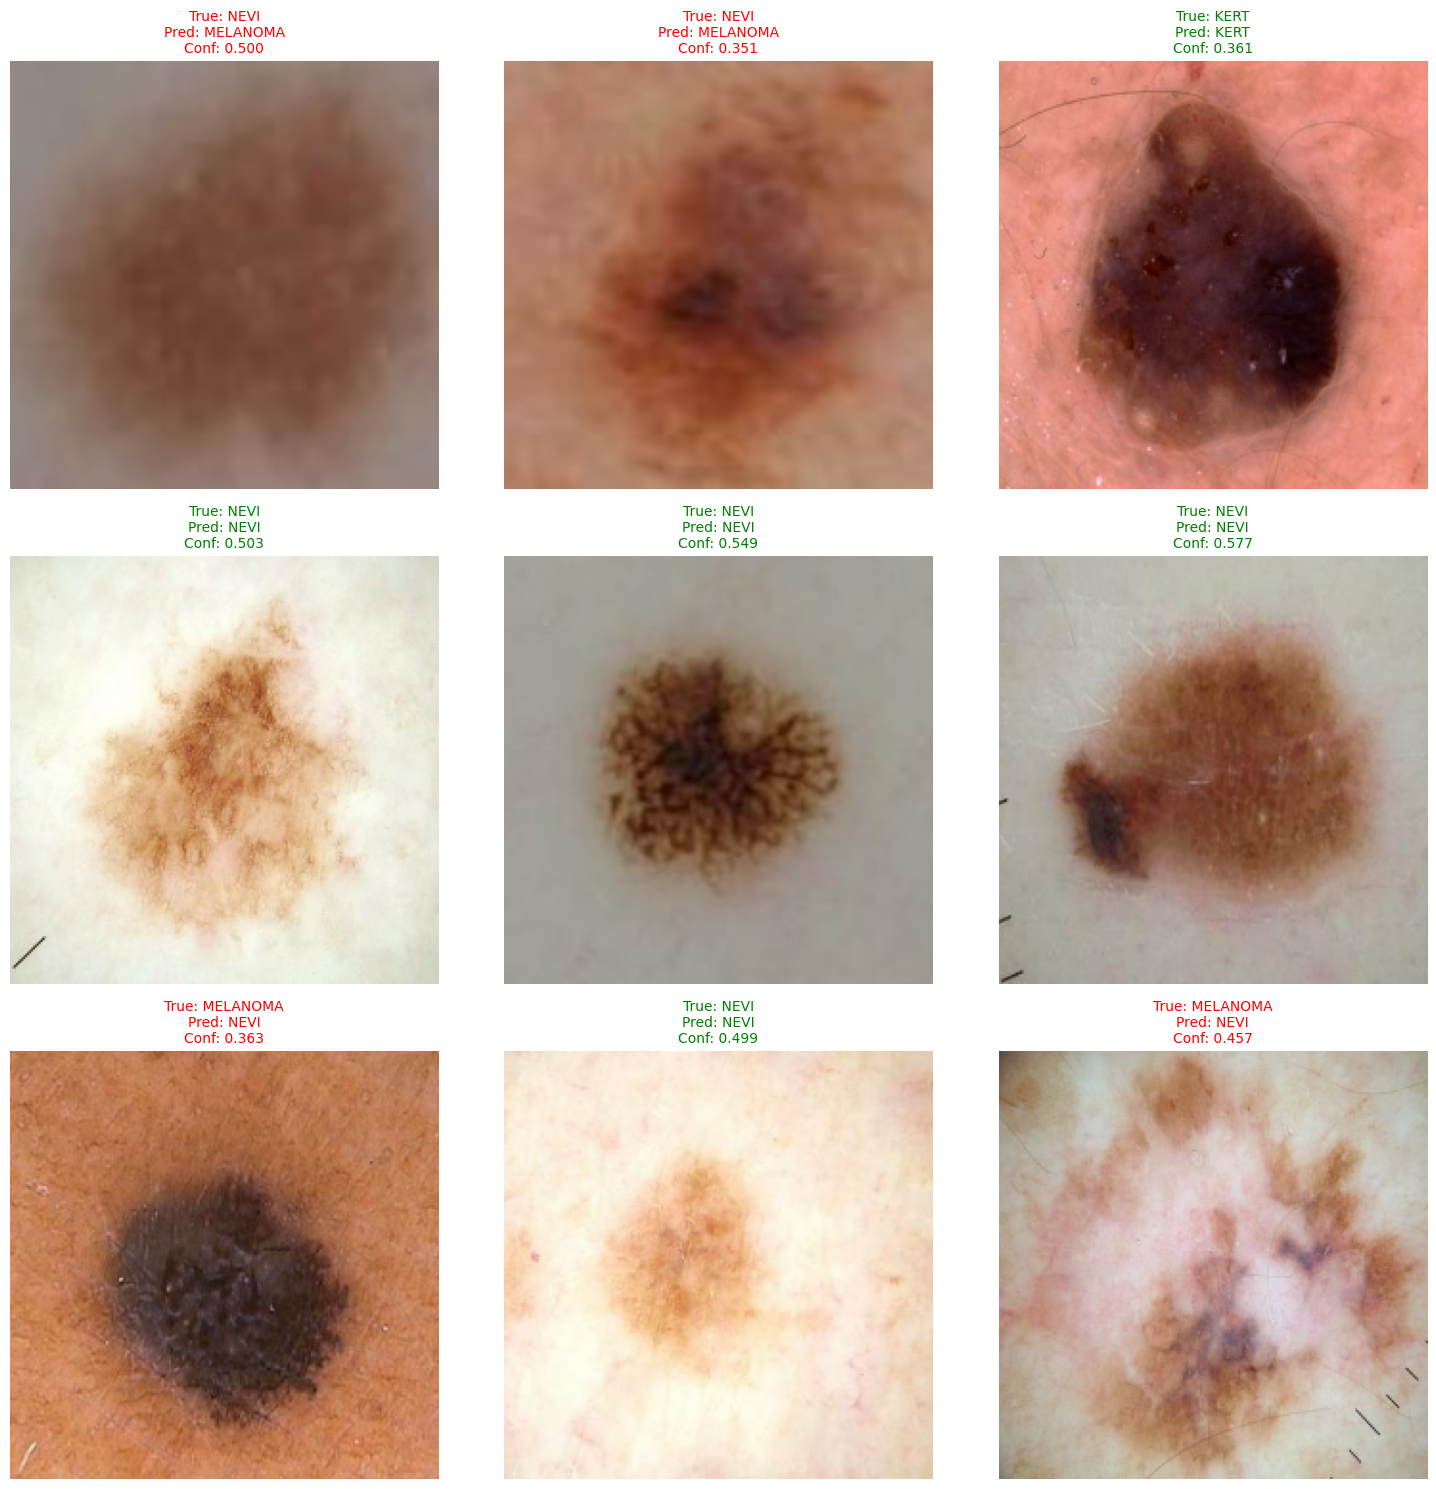

In [43]:
# Function to visualize predictions
def visualize_predictions(model, dataset, class_names, num_samples=9):
    """Visualize model predictions on sample images"""
    plt.figure(figsize=(15, 15))
    
    sample_batch = next(iter(dataset))
    images, labels = sample_batch[0][:num_samples], sample_batch[1][:num_samples]
    
    predictions = model.predict(images, verbose=0)
    
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        true_class = class_names[np.argmax(labels[i])]
        pred_class = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i])
        
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, validation_dataset, class_names)
